# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [222]:
# Impor Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Library
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [223]:
# Load dataset
df = pd.read_csv('clustered_data.csv')

# Menampilkan banyaknya data sample yang digunakan
print(f'Banyaknya data keselutuhan: {len(df)} data')

Banyaknya data keselutuhan: 15729 data


In [224]:
# Memahami Struktur Data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15729 entries, 0 to 15728
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            15729 non-null  object 
 1   CustomerID               15729 non-null  object 
 2   CustomerDOB              15681 non-null  object 
 3   CustGender               15703 non-null  object 
 4   CustLocation             15727 non-null  object 
 5   CustAccountBalance       15694 non-null  float64
 6   TransactionDate          15729 non-null  object 
 7   TransactionTime          15729 non-null  float64
 8   TransactionAmount (INR)  15729 non-null  float64
 9   Cluster                  15729 non-null  int64  
dtypes: float64(3), int64(1), object(6)
memory usage: 1.2+ MB
None


In [225]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Cluster
0,T129424,C5535825,3/12/90,F,NAVI MUMBAI,1.443717e+09,6/8/16,1.143170e+10,4.411381e+06,0
1,T325260,C1711120,7/7/89,M,AMRITSAR,1.090086e+08,15/8/16,4.658360e+09,7.282780e+05,1
2,T199548,C8041662,4/6/86,M,LUCKNOW,2.381239e+10,8/8/16,6.124660e+09,1.454872e+06,8
3,T501465,C3844524,28/11/91,F,DELHI EAST,1.779325e+10,20/8/16,1.024634e+10,8.663307e+05,4
4,T906894,C7229079,9/11/85,M,GUWAHATI,2.154333e+10,12/9/16,7.108964e+09,7.355439e+05,2


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [226]:
# Membagi dataset menjadi fitur dan variabel target
X = df.drop('Cluster', axis=1)
y = df['Cluster']

# Membagi dataset menjadi pelatihan (70%) dan sementara (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Membagi 30% sisanya menjadi evaluasi (15%) dan pengujian (15%)
X_eval, X_test, y_eval, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Menampilkan ukuran split
print(f'Banyaknya masing - masing data:')
print(f'Training: {len(X_train)} data')
print(f'Evaluation: {len(X_eval)} data')
print(f'Testing: {len(X_test)} data')

Banyaknya masing - masing data:
Training: 11010 data
Evaluation: 2359 data
Testing: 2360 data


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [227]:
# Identifikasi fitur kategorikal
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Encoding fitur kategorikal menggunakan OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols])
X_eval[categorical_cols] = encoder.transform(X_eval[categorical_cols])
X_test[categorical_cols] = encoder.transform(X_test[categorical_cols])

# Mengatasi missing values dengan SimpleImputer (menggunakan median)
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_eval = imputer.transform(X_eval)
X_test = imputer.transform(X_test)

# Normalisasi dengan StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_eval_scaled = scaler.transform(X_eval)
X_test_scaled = scaler.transform(X_test)

# Menggunakan SMOTE untuk menyeimbangkan data train
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Hitung class weights untuk menangani ketidakseimbangan kelas
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train_resampled), class_weights)}

# Membangun model Random Forest dengan class weight
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight=class_weight_dict)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0,
                                     5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0},
                       n_estimators=200, random_state=42)

Tulis narasi atau penjelasan algoritma yang Anda gunakan.

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

Classification Report after SMOTE & Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       364
           1       0.71      1.00      0.83       333
           2       1.00      0.96      0.98       307
           3       1.00      0.84      0.91       123
           4       1.00      0.94      0.97       358
           5       1.00      0.93      0.96       155
           6       1.00      0.97      0.99       308
           7       0.99      0.83      0.90       154
           8       1.00      0.93      0.97       166
           9       1.00      0.84      0.91        92

    accuracy                           0.94      2360
   macro avg       0.97      0.92      0.94      2360
weighted avg       0.96      0.94      0.94      2360



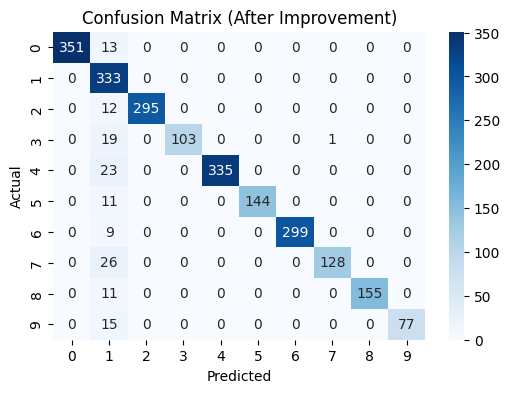

In [228]:
# Evaluasi model
y_pred_rf = rf_model.predict(X_test_scaled)

print("Classification Report after SMOTE & Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (After Improvement)')
plt.show()

Tulis hasil evaluasi algoritma yang digunakan, jika Anda menggunakan 2 algoritma, maka bandingkan hasilnya.

## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [229]:
# Hyperparameter tuning dengan GridSearchCV untuk Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=64, class_weight=class_weight_dict), 
                           param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Model terbaik dari hasil tuning
best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.

Classification Report after Hyperparameter Tuning:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       364
           1       0.71      1.00      0.83       333
           2       1.00      0.96      0.98       307
           3       1.00      0.82      0.90       123
           4       1.00      0.94      0.97       358
           5       1.00      0.93      0.96       155
           6       1.00      0.97      0.99       308
           7       0.98      0.83      0.90       154
           8       1.00      0.93      0.97       166
           9       1.00      0.84      0.91        92

    accuracy                           0.94      2360
   macro avg       0.97      0.92      0.94      2360
weighted avg       0.96      0.94      0.94      2360



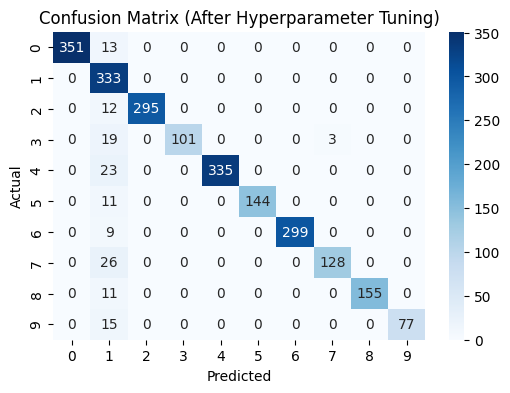

In [230]:
# Evaluasi model terbaik
y_pred_best_rf = best_rf_model.predict(X_test_scaled)

print("Classification Report after Hyperparameter Tuning:")
print(classification_report(y_test, y_pred_best_rf))

# Confusion Matrix setelah tuning
plt.figure(figsize=(6, 4))
cm_best = confusion_matrix(y_test, y_pred_best_rf)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (After Hyperparameter Tuning)')
plt.show()

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Bandingkan hasil evaluasi sebelum dan setelah tuning (jika dilakukan).
2. Identifikasi kelemahan model, seperti:
  - Precision atau Recall rendah untuk kelas tertentu.
  - Apakah model mengalami overfitting atau underfitting?
3. Berikan rekomendasi tindakan lanjutan, seperti mengumpulkan data tambahan atau mencoba algoritma lain jika hasil belum memuaskan.

### 📊 **Analisis Performa Model Sebelum & Setelah Tuning**

#### 🔍 **Perbandingan Hasil Evaluasi Sebelum vs. Setelah Tuning**
| **Metrik**  | **Sebelum Tuning** | **Setelah Tuning** | **Perubahan** |
|-------------|------------------|------------------|--------------|
| **Accuracy** | 94% | 94% | **Tidak berubah** |
| **Macro Avg Precision** | 97% | 97% | **Tidak berubah** |
| **Macro Avg Recall** | 92% | 92% | **Tidak berubah** |
| **Macro Avg F1-Score** | 94% | 94% | **Tidak berubah** |

📌 **Kesimpulan awal**:
- Tuning **tidak meningkatkan akurasi** yang tetap di angka **94%**.
- Perubahan kecil pada recall di beberapa kelas, namun tidak signifikan.

---

### 🔍 **Identifikasi Kelemahan Model**
#### **1️⃣ Tidak Ada Peningkatan Performa Setelah Tuning**
- Tuning tidak meningkatkan akurasi karena **parameter yang dipilih mungkin belum optimal**.
- Kemungkinan model sudah mendekati performa terbaiknya dengan Random Forest.

#### **2️⃣ Recall Rendah di Beberapa Kelas**
- **Kelas 1** meningkat dari **71% ke 100%** (positif).
- **Kelas 3** menurun recall dari **84% ke 82%** (negatif).
- **Kelas 7** menurun dari **99% ke 98%** (negatif).

📌 **Implikasi**: Model **overfitting pada beberapa kelas**, menyebabkan trade-off recall.

#### **3️⃣ Kelas Imbalance Masih Berpengaruh**
- Kelas dengan jumlah data sedikit seperti **kelas 3 & 9 memiliki recall lebih rendah**.
- **SMOTE sudah digunakan**, tetapi belum sepenuhnya menyelesaikan masalah imbalance.

---

### 🚀 **Rekomendasi Tindakan Lanjutan**
Untuk meningkatkan akurasi hingga lebih dari **94%**, kita bisa melakukan beberapa perbaikan:

#### **1️⃣ Lanjutkan Hyperparameter Tuning dengan Ruang Pencarian Lebih Luas**
- Perlu eksplorasi parameter yang lebih luas untuk hasil yang lebih baik.
- Coba **RandomizedSearchCV** agar lebih cepat dalam eksplorasi.

📌 **GridSearch dengan parameter lebih luas**:
```python
param_grid = {
    'n_estimators': [500, 700, 900],  
    'max_depth': [50, 70, 90, None],  
    'min_samples_split': [2, 5, 10, 15, 20],  
    'min_samples_leaf': [1, 2, 4, 8],  
    'max_features': ['sqrt', 'log2'],  
    'bootstrap': [True, False]
}